In [1]:
import tensorflow as tf
import numpy as np
import math
import sklearn

In [2]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [257]:
## 我们使用一个简单的CNN神经网络进行手写数字的识别， 可以达到比之前方法高的多的准确率

In [258]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#x_train0 = [x_train.reshape(784,1) for i in x_train]

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


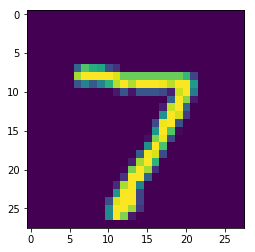

In [259]:
plt.figure()
img=x_test[0].reshape(28,28)
plt.imshow(img)
plt.show()

In [260]:
# prepare for pca
x_train0 = x_train.reshape(60000,784)
x_test0=x_test.reshape(10000,784)
X = np.append(x_train0,x_test0,axis=0)
np.shape(X)

(70000, 784)

In [261]:
import numpy as np
def svd_pca(data, k):
    """Reduce DATA using its K principal components."""
    data = data.astype("float64")
    data -= np.mean(data, axis=0)
    U, S, V = np.linalg.svd(data, full_matrices=False)
    return U[:,:k].dot(np.diag(S)[:k,:k])
X_pca = svd_pca(X,50)

In [262]:
X_pca[:,3:5]

array([[-2.1839137 ,  0.19298083],
       [-1.90228783,  3.2999151 ],
       [ 2.07537594,  1.22807578],
       ..., 
       [-1.70586104, -2.64176687],
       [-1.10787816,  0.6088774 ],
       [ 3.10217654, -0.69682747]])

In [234]:
train_pca = X_pca[:60000,:25]
test_pca = X_pca[60000:,:25]

In [263]:
import sklearn 
from sklearn.linear_model import LogisticRegression

for i in range (5):
    train_pca = X_pca[:60000,:5+10*i]
    test_pca = X_pca[60000:,:5+10*i]
    y_train0=y_train.nonzero()[1].reshape(-1,1)
    model=LogisticRegression()
    model.fit(train_pca,y_train0)
    y = model.predict(test_pca)
    a=(y==y_test)
    print (sum(y==y_test.nonzero()[1])/len(y))

/home/cruiser/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cruiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


0.6535
0.8257
0.8816
0.8914
0.9032


In [265]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
#Flattens the input. Does not affect the batch size.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# fully connnected layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 3s - loss: 0.3215 - acc: 0.9031 - val_loss: 0.0756 - val_acc: 0.9765
Epoch 2/12
60000/60000 [==============================] - 3s - loss: 0.1106 - acc: 0.9674 - val_loss: 0.0530 - val_acc: 0.9831
Epoch 3/12
60000/60000 [==============================] - 3s - loss: 0.0865 - acc: 0.9752 - val_loss: 0.0444 - val_acc: 0.9852
Epoch 4/12
60000/60000 [==============================] - 3s - loss: 0.0699 - acc: 0.9788 - val_loss: 0.0383 - val_acc: 0.9870
Epoch 5/12
60000/60000 [==============================] - 3s - loss: 0.0626 - acc: 0.9817 - val_loss: 0.0352 - val_acc: 0.9884
Epoch 6/12
60000/60000 [==============================] - 3s - loss: 0.0552 - acc: 0.9831 - val_loss: 0.0333 - val_acc: 0.9887
Epoch 7/12
60000/60000 [==============================] - 3s - loss: 0.0511 - acc: 0.9848 - val_loss: 0.0298 - val_

In [167]:
32*64*3*3

18432

In [266]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
__________

## Plot  intermediate feature maps

In [239]:
def make_intermediate_function(model, layer_ind):
    input_node = model.input
    output_layer = model.layers[layer_ind]
    output_node = output_layer.output 
    name = output_layer.name
    keras_func = K.function([input_node], [output_node])
    func = lambda x: keras_func([x.reshape((1,) +  x.shape)])[0][0, :]
    return name, func

def plot_features(input_image, name, func):
    output_features = func(input_image)
    n_ims = output_features.shape[-1]
    n_cols = 8
    f, axarr = plt.subplots(math.ceil(n_ims / n_cols), n_cols)
    axarr = axarr.reshape(-1)
    for i in range(n_ims):
        canvas = axarr[i]
        canvas.imshow(output_features[:, :, i])
        canvas.axis('off')
    f.suptitle('Output Feature Maps of Layer {}'.format(name))
    
def plot_all_features(input_image, model, layer_inds):
#     fig = plt.figure()
    plt.imshow(input_image.reshape(input_image.shape[:-1]), cmap='gray')
    plt.title('Input Image')
    for ind in layer_inds:
        name, func = make_intermediate_function(model, ind)
        plot_features(input_image, name, func)

TypeError: Invalid dimensions for image data

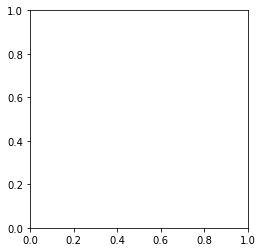

In [268]:
plot_all_features(x_test[60], model, [0, 1, 2])

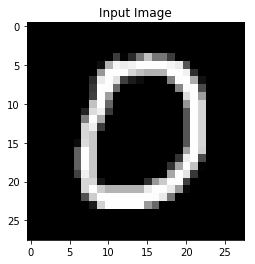

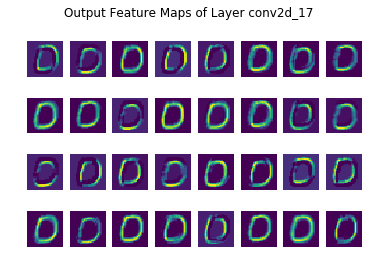

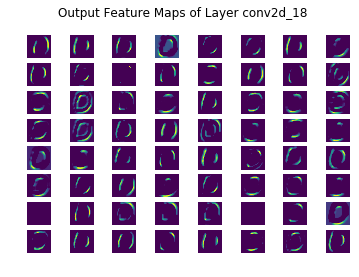

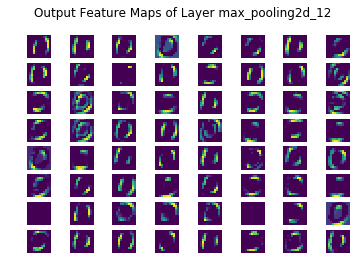

In [241]:
plot_all_features(x_test[10], model, [0, 1, 2])

Method with traditional network 

In [272]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [273]:
batch_size = 32
num_classes = 10
epochs = 50
data_augmentation = True

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [274]:
x_train=x_train[:5000]
y_train=y_train[:5000]
x_test=x_test[:1000]
y_test=y_test[:1000]

# Convert class vectors to binary class matrices.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/50
156/156 [==============================] - 1s - loss: 2.1549 - acc: 0.2077 - val_loss: 1.9738 - val_acc: 0.3200
Epoch 2/50
156/156 [==============================] - 1s - loss: 1.9522 - acc: 0.2997 - val_loss: 1.8299 - val_acc: 0.3800
Epoch 3/50
156/156 [==============================] - 1s - loss: 1.8491 - acc: 0.3357 - val_loss: 1.8042 - val_acc: 0.3580
Epoch 4/50
156/156 [==============================] - 1s - loss: 1.7896 - acc: 0.3574 - val_loss: 1.7030 - val_acc: 0.4260
Epoch 5/50
156/156 [==============================] - 1s - loss: 1.7414 - acc: 0.3824 - val_loss: 1.6626 - val_acc: 0.4320
Epoch 6/50
156/156 [==============================] - 1s - loss: 1.7017 - acc: 0.3824 - val_loss: 1.6089 - val_acc: 0.4400
Epoch 7/50
156/156 [==============================] - 1s - loss: 1.6546 - acc: 0.4207 - val_loss: 1.5736 - val_acc: 0.4390
Epoch 8/50
156/156 [==============================] - 1s - loss: 1.6242 - acc: 0.4209 - val_loss: 1.5824

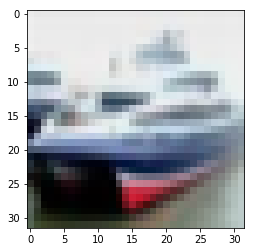

In [252]:
plt.figure()
img=x_test[1].reshape(32,32,3)
plt.imshow(img)
plt.show()

In [253]:
np.shape(x_test[0][:,:,0])

(32, 32)

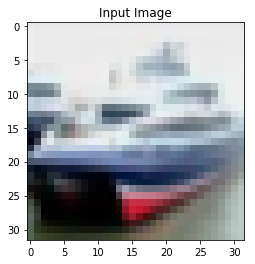

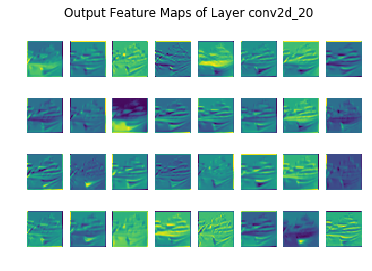

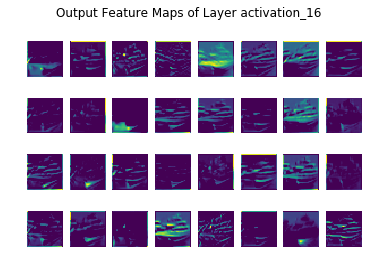

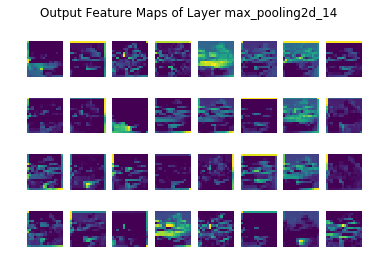

In [254]:
def make_intermediate_function(model, layer_ind):
    input_node = model.input
    output_layer = model.layers[layer_ind]
    output_node = output_layer.output 
    name = output_layer.name
    keras_func = K.function([input_node], [output_node])
    func = lambda x: keras_func([x.reshape((1,) +  x.shape)])[0][0, :]
    return name, func

def plot_features(input_image, name, func):
    output_features = func(input_image)
    n_ims = output_features.shape[-1]
    n_cols = 8
    f, axarr = plt.subplots(math.ceil(n_ims / n_cols), n_cols)
    axarr = axarr.reshape(-1)
    for i in range(n_ims):
        canvas = axarr[i]
        canvas.imshow(output_features[:, :, i])
        canvas.axis('off')
    f.suptitle('Output Feature Maps of Layer {}'.format(name))
    
def plot_all_features(input_image, model, layer_inds):
#     fig = plt.figure()
    plt.imshow(input_image.reshape(input_image.shape), cmap='gray')
    plt.title('Input Image')
    for ind in layer_inds:
        name, func = make_intermediate_function(model, ind)
        plot_features(input_image, name, func)

plot_all_features(x_test[1], model, [0,1,2])